In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import ipywidgets as widgets
from ipywidgets import interact

import numpy as np

from scipy.interpolate import interp1d
# from dtaidistance import dtw
from scipy.stats import pearsonr

from scipy import spatial
import itertools

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN


In [2]:
raw_df = pd.read_csv("imdb_top_250_series_episode_ratings.csv")

raw_df.head()

,id,type,season,episode,titleText,releaseYear,plot,aggregateRating,voteCount,canRate,...,releaseDate.day,releaseDate.year,releaseDate.__typename,image.url,image.maxHeight,image.maxWidth,image.caption,title,series.id,releaseDate
0,tt0959621,tvEpisode,1,1,Pilot,2008.0,"Diagnosed with terminal lung cancer, chemistry...",9.0,44315,True,...,20.0,2008.0,ReleaseDate,https://m.media-amazon.com/images/M/MV5BNWRjMj...,1814,3224,Bryan Cranston in Pilot (2008),Breaking Bad,tt0903747,NaN
1,tt1054724,tvEpisode,1,2,Cat's in the Bag...,2008.0,After their first drug deal goes terribly wron...,8.6,32318,True,...,27.0,2008.0,ReleaseDate,https://m.media-amazon.com/images/M/MV5BNmI5MT...,705,940,Aaron Paul in Breaking Bad (2008),Breaking Bad,tt0903747,NaN
2,tt1054725,tvEpisode,1,3,...And the Bag's in the River,2008.0,Walt and Jesse clean up after the bathtub inci...,8.7,31307,True,...,10.0,2008.0,ReleaseDate,https://m.media-amazon.com/images/M/MV5BMjI4Nj...,375,500,Bryan Cranston and Aaron Paul in Breaking Bad ...,Breaking Bad,tt0903747,NaN
3,tt1054726,tvEpisode,1,4,Cancer Man,2008.0,Walt tells the rest of his family about his ca...,8.2,30119,True,...,17.0,2008.0,ReleaseDate,https://m.media-amazon.com/images/M/MV5BM2ExYj...,1333,1864,Bryan Cranston and Anna Gunn in Breaking Bad (...,Breaking Bad,tt0903747,NaN
4,tt1054727,tvEpisode,1,5,Gray Matter,2008.0,Walt rejects everyone who tries to help him wi...,8.3,29611,True,...,24.0,2008.0,ReleaseDate,https://m.media-amazon.com/images/M/MV5BNTgwOT...,1080,1920,Bryan Cranston and Anna Gunn in Breaking Bad (...,Breaking Bad,tt0903747,NaN


In [20]:
raw_df['series.id'].unique().shape

(250,)

In [3]:
raw_df['releaseDate.year'].value_counts().sort_index()

releaseDate.year
1959.0     12
1960.0     47
1961.0     59
1962.0     36
1963.0     31
         ... 
2021.0    503
2022.0    573
2023.0    477
2024.0    258
2025.0     12
Name: count, Length: 63, dtype: int64

In [4]:
raw_df.groupby('title')['releaseDate.year'].max().sort_values().head(50)

title
The Twilight Zone                      1964.0
The Bugs Bunny Show                    1972.0
The World at War                       1974.0
I, Claudius                            1976.0
Fawlty Towers                          1979.0
Cosmos                                 1980.0
Yes Minister                           1984.0
The Adventures of Sherlock Holmes      1985.0
Blackadder II                          1986.0
Blackadder the Third                   1987.0
Ramayan                                1988.0
The Return of Sherlock Holmes          1988.0
Yes, Prime Minister                    1988.0
Lonesome Dove                          1989.0
Mahabharat                             1989.0
Blackadder Goes Forth                  1989.0
Dekalog                                1990.0
The Civil War                          1990.0
Star Trek: The Next Generation         1994.0
Batman: The Animated Series            1995.0
Mr. Bean                               1995.0
Pride and Prejudice         

In [32]:
df = raw_df.loc[(raw_df['season'] != 'Unknown') & (raw_df['episode'] != '0')] # drop any special eps or upcoming eps

df = df[['title', 'series.id', 'titleText', 'id', 'season', 'episode', 'aggregateRating']].copy() # filter on desired columns

df['season'] = df['season'].astype(int)
df['episode'] = df['episode'].astype(int)

df = df.dropna(subset=["aggregateRating"]) # some specials or yet unreleased episodes have na for their rating

tv_last_release_year = raw_df.groupby('title')['releaseDate.year'].max()
min_year_list = tv_last_release_year[tv_last_release_year >= 1997].index.tolist()
# df = df.loc[df['title'].isin(min_year_list)].copy()

df.head()

,title,series.id,titleText,id,season,episode,aggregateRating
0,Breaking Bad,tt0903747,Pilot,tt0959621,1,1,9.0
1,Breaking Bad,tt0903747,Cat's in the Bag...,tt1054724,1,2,8.6
2,Breaking Bad,tt0903747,...And the Bag's in the River,tt1054725,1,3,8.7
3,Breaking Bad,tt0903747,Cancer Man,tt1054726,1,4,8.2
4,Breaking Bad,tt0903747,Gray Matter,tt1054727,1,5,8.3


In [30]:
tv_last_release_year[tv_last_release_year < 1997].sort_values()

title
The Twilight Zone                    1964.0
The Bugs Bunny Show                  1972.0
The World at War                     1974.0
I, Claudius                          1976.0
Fawlty Towers                        1979.0
Cosmos                               1980.0
Yes Minister                         1984.0
The Adventures of Sherlock Holmes    1985.0
Blackadder II                        1986.0
Blackadder the Third                 1987.0
The Return of Sherlock Holmes        1988.0
Yes, Prime Minister                  1988.0
Ramayan                              1988.0
Lonesome Dove                        1989.0
Mahabharat                           1989.0
Blackadder Goes Forth                1989.0
The Civil War                        1990.0
Dekalog                              1990.0
Star Trek: The Next Generation       1994.0
Mr. Bean                             1995.0
Batman: The Animated Series          1995.0
Das Boot                             1996.0
Pride and Prejudice       

# Highest and lowest ranked episode and season per series

In [33]:
tv_highest_rated_ep = df.groupby('title')['aggregateRating'].max().sort_values(ascending=False)

tv_highest_rated_ep.head(10)

title
Breaking Bad                           10.0
Better Call Saul                        9.9
Avatar: The Last Airbender              9.9
Bluey                                   9.9
Behzat Ç: An Ankara Detective Story     9.9
Demon Slayer: Kimetsu no Yaiba          9.9
BoJack Horseman                         9.9
Gravity Falls                           9.9
Game of Thrones                         9.9
Succession                              9.9
Name: aggregateRating, dtype: float64

In [34]:
df.loc[df['aggregateRating']==10]

,title,series.id,titleText,id,season,episode,aggregateRating
59,Breaking Bad,tt0903747,Ozymandias,tt2301451,5,14,10.0


In [35]:
tv_lowest_rated_ep = df.groupby('title')['aggregateRating'].min().sort_values()

tv_lowest_rated_ep.tail(5)

title
Planet Earth II          8.7
The Last Dance           8.8
The Beatles: Get Back    8.9
Chernobyl                9.3
Sapne Vs Everyone        9.5
Name: aggregateRating, dtype: float64

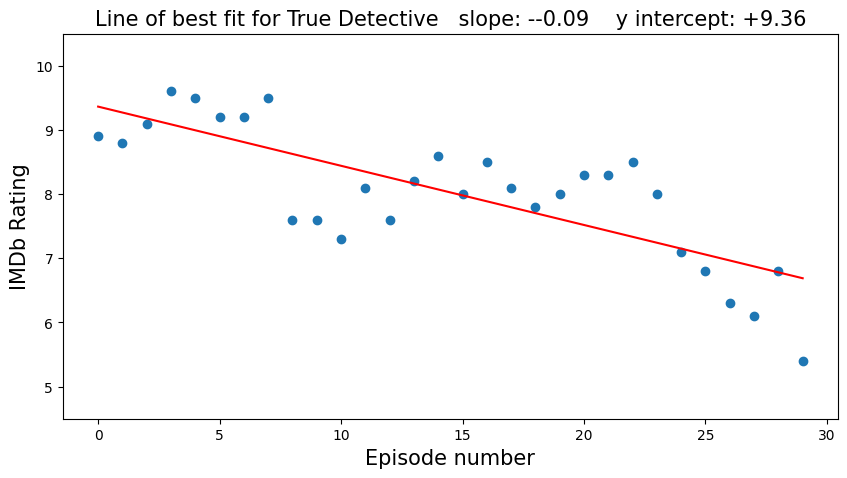

-0.09223581757508346
 
0.008566 x + 8.209


In [175]:
title_query = "True Detective"

y = df.loc[df['title']==title_query].sort_values(by=['season', 'episode']).reset_index(drop=True).aggregateRating.values
x = np.arange(0,len(y))

#Fit line
slope, intercept = np.polyfit(x, y, 1)
if slope < 0:
    sign_slope = '-'
else:
    sign_slope = '+'

#Plot
fig, ax = plt.subplots(1,1, figsize=(10, 5))

plt.ylim(4.5, 10.5)
plt.scatter(x, y)  # episode ratings
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color = 'r') # line of  est fit

# model = np.poly1d(np.polyfit(x, y, 2))
# polyline = np.linspace(0, len(x), 100)
# plt.plot(polyline, model(polyline))

ax.set_xlabel("Episode number", fontsize=15)
ax.set_ylabel("IMDb Rating", fontsize=15)
ax.set_title(f"Line of best fit for {title_query}   slope: {sign_slope}{round(slope, 2)}    y intercept: +{round(intercept, 2)}",
             fontsize=15)

plt.show()

print(slope)
print(model)

In [37]:
df.loc[(df['series.id']=='tt0052520')]

,title,series.id,titleText,id,season,episode,aggregateRating
786,The Twilight Zone,tt0052520,Where Is Everybody?,tt0734692,1,1,7.9
787,The Twilight Zone,tt0052520,One for the Angels,tt0734609,1,2,7.6
788,The Twilight Zone,tt0052520,Mr. Denton on Doomsday,tt0734592,1,3,7.1
789,The Twilight Zone,tt0052520,The Sixteen-Millimeter Shrine,tt0734626,1,4,6.8
790,The Twilight Zone,tt0052520,Walking Distance,tt0734689,1,5,8.2
...,...,...,...,...,...,...,...
937,The Twilight Zone,tt0052520,Mr. Garrity and the Graves,tt0734594,5,32,7.5
938,The Twilight Zone,tt0052520,The Brain Center at Whipple's,tt0734633,5,33,6.6
939,The Twilight Zone,tt0052520,Come Wander with Me,tt0734560,5,34,6.2
940,The Twilight Zone,tt0052520,The Fear,tt0734638,5,35,7.1


In [38]:
def heatmap_tv_series(series_name):
    
    if series_name == 'The Office':
        tv = df.loc[(df['series.id']=='tt0386676')].copy()
    else:
        tv = df.loc[(df['title']==series_name)].copy()
    tv_pivot = tv.pivot(index='season', 
                           columns='episode',
                          values='aggregateRating')
    
    fig, ax = plt.subplots(1,1, figsize=(20, 7))
    sns.heatmap(tv_pivot, 
                annot=True, 
                cbar=False,
                cmap="RdYlGn",
               center=7,
               linewidths=0.07,
               square=False,
               annot_kws={"size": 12})  

    ax.axes.set_title("",fontsize=20)
    ax.set_xlabel("Episode",fontsize=15)
    ax.set_ylabel("Season",fontsize=15)
#     ax.set_title(f"Heatmap of IMDb episode ratings for {series_name}",fontsize=30)

    ax.tick_params(left=False, bottom=False)
    
    plt.yticks(rotation = 0, fontsize='large')
    plt.xticks(fontsize='large')

    plt.show()
    
dropdown_list_order = df.title.sort_values().unique().tolist()
n_widget = widgets.Dropdown(options=df.title.sort_values().unique().tolist(), value='Top Gear', description='TV Series')

widgets.interact(heatmap_tv_series, series_name=n_widget);

interactive(children=(Dropdown(description='TV Series', index=227, options=('1883', 'Adventure Time', 'Africa'…

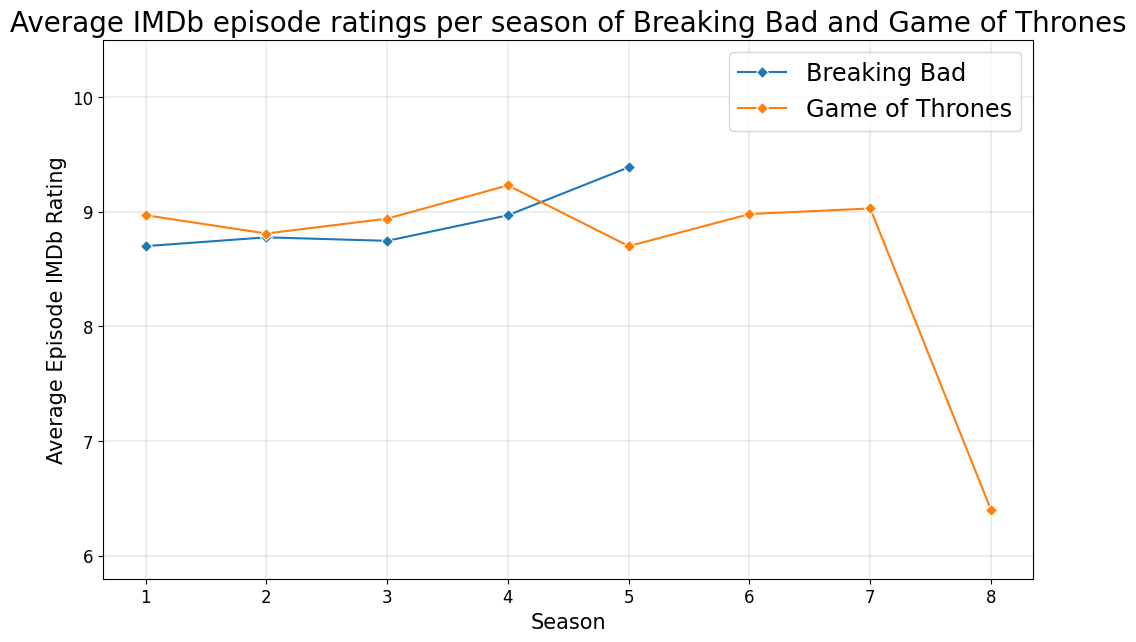

In [39]:
data_for_plot = df.loc[df['title'].isin(["Breaking Bad", "Game of Thrones"])].groupby(['title','season'])['aggregateRating'].mean().reset_index()

fig, ax = plt.subplots(1,1, figsize=(12, 7))

sns.lineplot(x="season",
             y="aggregateRating",
            hue="title",
            data=data_for_plot,
             marker='D'
          )
           
plt.ylim(5.8, 10.5)  # Set the y-axis limits from 0 to 8

ax.axes.set_title("Average IMDb episode ratings per season of Breaking Bad and Game of Thrones",fontsize=20)
ax.set_xlabel("Season",fontsize=15)
ax.set_ylabel("Average Episode IMDb Rating",fontsize=15)

ax.yaxis.set_tick_params(labelsize = 12)
ax.xaxis.set_tick_params(labelsize = 12)

plt.grid(True, color='black', linewidth=.1)

plt.legend(fontsize='xx-large')

plt.show()

# Clustering

In [40]:
top_season_avg_df = df.groupby(['series.id', 'season'])['aggregateRating'].mean().reset_index().groupby('series.id')['aggregateRating'].max().reset_index().rename(columns={'aggregateRating': 'top_season_avg'})
top_season_avg_df.set_index('series.id', inplace=True)
top_season_avg_df

,top_season_avg
series.id,
tt0052520,7.630556
tt0053488,7.915385
tt0063929,8.107692
tt0071075,8.638462
tt0072500,8.850000
...,...
tt9253866,8.975000
tt9335498,8.722222
tt9432978,8.700000


In [41]:
bottom_season_avg_df = df.groupby(['series.id', 'season'])['aggregateRating'].mean().reset_index().groupby('series.id')['aggregateRating'].min().reset_index().rename(columns={'aggregateRating': 'bottom_season_avg'})
bottom_season_avg_df.set_index('series.id', inplace=True)
bottom_season_avg_df

,bottom_season_avg
series.id,
tt0052520,7.211111
tt0053488,7.042308
tt0063929,7.366667
tt0071075,8.638462
tt0072500,8.666667
...,...
tt9253866,8.650000
tt9335498,7.900000
tt9432978,8.600000


In [42]:
all_eps_avg_df = df.groupby(['series.id'])['aggregateRating'].mean().reset_index().groupby('series.id')['aggregateRating'].max().reset_index().rename(columns={'aggregateRating': 'all_eps_avg'})
all_eps_avg_df.set_index('series.id', inplace=True)
all_eps_avg_df

,all_eps_avg
series.id,
tt0052520,7.448718
tt0053488,7.538462
tt0063929,7.928889
tt0071075,8.638462
tt0072500,8.758333
...,...
tt9253866,8.866667
tt9335498,8.404762
tt9432978,8.640000


In [43]:
highest_rated_ep_df = df.groupby(['series.id'])['aggregateRating'].max().reset_index().rename(columns={'aggregateRating': 'highest_rated_ep'})
highest_rated_ep_df.set_index('series.id', inplace=True)
highest_rated_ep_df

,highest_rated_ep
series.id,
tt0052520,9.1
tt0053488,8.4
tt0063929,8.9
tt0071075,9.2
tt0072500,9.3
...,...
tt9253866,9.2
tt9335498,9.9
tt9432978,9.4


In [44]:
lowest_rated_ep_df = df.groupby(['series.id'])['aggregateRating'].min().reset_index().rename(columns={'aggregateRating': 'lowest_rated_ep'})
lowest_rated_ep_df.set_index('series.id', inplace=True)
lowest_rated_ep_df

,lowest_rated_ep
series.id,
tt0052520,5.6
tt0053488,6.5
tt0063929,7.2
tt0071075,8.1
tt0072500,8.4
...,...
tt9253866,8.6
tt9335498,7.1
tt9432978,8.1


In [45]:
n_seasons_df = df.groupby(['series.id'])['season'].max().reset_index().rename(columns={'season': 'n_seasons'})
n_seasons_df.set_index('series.id', inplace=True)
n_seasons_df.sort_values(by='n_seasons')

,n_seasons
series.id,
tt0071075,1
tt0074006,1
tt0081834,1
tt0081846,1
tt0088484,1
...,...
tt4934214,17
tt0380136,21
tt0121955,26


In [46]:
n_episodes_df = df.groupby(['series.id'])['episode'].count().reset_index().rename(columns={'episode': 'n_episodes'})
n_episodes_df.set_index('series.id', inplace=True)
n_episodes_df.sort_values(by='n_episodes')

,n_episodes
series.id,
tt0314979,2
tt0081834,3
tt9735318,3
tt0203082,4
tt0417349,4
...,...
tt0229889,304
tt3530232,306
tt0121955,321


In [111]:
data_list = []

for s_id in df['series.id'].unique():
    
    # y = df.loc[df['title']==title].sort_values(by=['season', 'episode']).reset_index(drop=True).aggregateRating.values
    
#     w=3
#     y = df.loc[df['title']==title].sort_values(by=['season', 'episode']).reset_index(drop=True).aggregateRating.rolling(window=w).mean().values[w-1:]
    y = df.loc[df['series.id']==s_id].sort_values(by=['season', 'episode']).reset_index(drop=True).aggregateRating.values

    x = np.arange(0,len(y))

    model = np.poly1d(np.polyfit(x, y, 1))
    coefs = model.coefficients
    
    data_list.append({'series.id': s_id,
                     'trend_slope': coefs[0],
                     'constant_1': coefs[1]
                     })

del(x)
del(y)

series_slope_df = pd.DataFrame(data_list)
series_slope_df.set_index('series.id', inplace=True)
series_slope_df.head()

,trend_slope,constant_1
series.id,,
tt0903747,0.016366,8.460522
tt5491994,-0.094286,9.219048
tt0795176,-0.005455,8.809091
tt0185906,0.053939,8.787273
tt7366338,0.050000,9.420000


In [112]:
cluster_df = pd.concat([top_season_avg_df, bottom_season_avg_df, all_eps_avg_df, 
                        series_slope_df,
                       highest_rated_ep_df, lowest_rated_ep_df,
                       n_seasons_df, n_episodes_df], axis=1)
# cluster_df['series_id'] = cluster_df.index

cluster_df.reset_index(drop=False, inplace=True)

# id to title lookup
temp = df[['series.id', 'title']].drop_duplicates().copy().reset_index(drop=True)
title_keys = temp['series.id'].values.tolist()
title_values = temp['title'].values.tolist()
id_title_lookup = dict(map(lambda i,j : (i,j) , title_keys, title_values))

cluster_df['title'] = cluster_df['series.id'].apply(lambda x: id_title_lookup[x])

cluster_df['top_bottom_season_gap'] = cluster_df['top_season_avg'] - cluster_df['bottom_season_avg']

cluster_df.sort_values(by='n_seasons')

,series.id,top_season_avg,bottom_season_avg,all_eps_avg,trend_slope,constant_1,highest_rated_ep,lowest_rated_ep,n_seasons,n_episodes,title,top_bottom_season_gap
3,tt0071075,8.638462,8.638462,8.638462,0.006496,8.557265,9.2,8.1,1,26,The World at War,0.000000
5,tt0074006,8.546154,8.546154,8.546154,0.040110,8.305495,8.8,8.2,1,13,"I, Claudius",0.000000
7,tt0081834,8.633333,8.633333,8.633333,0.150000,8.483333,8.8,8.5,1,3,Das Boot,0.000000
8,tt0081846,8.900000,8.900000,8.900000,0.004945,8.870330,9.1,8.7,1,13,Cosmos,0.000000
12,tt0088484,8.266667,8.266667,8.266667,-0.017143,8.309524,8.5,8.0,1,6,Blackadder II,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
210,tt4934214,8.310000,7.510000,7.905263,-0.002446,8.089938,8.8,7.3,17,152,Taskmaster,0.800000
71,tt0380136,7.633333,6.600000,7.105605,-0.003207,7.647604,8.1,5.1,21,339,QI,1.033333
38,tt0121955,8.578571,7.300000,7.985047,-0.001698,8.256667,9.6,6.2,26,321,South Park,1.278571
146,tt1628033,8.625000,2.550000,7.433610,-0.010140,8.650410,9.4,2.2,33,241,Top Gear,6.075000


In [113]:
print(f"Number of series with less than 3 season: {len(cluster_df.loc[cluster_df['n_seasons'] <= 2])}")
cluster_df = cluster_df.loc[cluster_df['n_seasons'] >= 3]

print(f"Number of series with more than 350 episodes: {len(cluster_df.loc[cluster_df['n_episodes'] > 350])}")
cluster_df = cluster_df.loc[cluster_df['n_episodes'] <= 350]

print(f"Number of series remaining: {len(cluster_df)}")


Number of series with less than 3 season: 111
Number of series with more than 350 episodes: 1
Number of series remaining: 138


In [337]:
cluster_cols = ['top_season_avg', 'bottom_season_avg', 'top_bottom_season_gap',
                'all_eps_avg', #  'n_seasons',
               'trend_slope', 'constant_1',
                'highest_rated_ep', 'lowest_rated_ep']

X = cluster_df[cluster_cols]

X.rename(columns={'title': 'Title',
                 'top_season_avg': 'Highest Season Average',
                 'bottom_season_avg': 'Lowest Season Average',
                 'top_bottom_season_gap': 'Season Average Difference',
                 'all_eps_avg': 'All Episodes Average',
                 'trend_slope': 'Episode Rating Slope',
                 'constant_1': 'Episode Rating Y Intercept',
                 'highest_rated_ep': 'Highest Rated Episode',
                 'lowest_rated_ep': 'Lowest Rated Episode'}, inplace=True)

# round(X.loc[X['Title'].isin(['The Sopranos', 'The Wire', 'Succession', 'Doctor Who', 'Dark'])].sort_values(by='All Episodes Average', ascending=False).head(5), 2)

/var/folders/xr/_sn2jn9s3xd13fp9ljzys7tm0000gn/T/ipykernel_33406/3217263043.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rename(columns={'title': 'Title',


In [338]:
X.corr()

,Highest Season Average,Lowest Season Average,Season Average Difference,All Episodes Average,Episode Rating Slope,Episode Rating Y Intercept,Highest Rated Episode,Lowest Rated Episode
Highest Season Average,1.000000,0.361778,0.129227,0.853895,0.123058,0.602853,0.609031,0.296827
Lowest Season Average,0.361778,1.000000,-0.877696,0.691557,0.430695,0.044350,0.214072,0.827513
Season Average Difference,0.129227,-0.877696,1.000000,-0.296651,-0.394858,0.262715,0.085364,-0.727616
All Episodes Average,0.853895,0.691557,-0.296651,1.000000,0.289651,0.547669,0.557383,0.581959
Episode Rating Slope,0.123058,0.430695,-0.394858,0.289651,1.000000,-0.463251,0.046419,0.430746
Episode Rating Y Intercept,0.602853,0.044350,0.262715,0.547669,-0.463251,1.000000,0.368865,-0.013315
Highest Rated Episode,0.609031,0.214072,0.085364,0.557383,0.046419,0.368865,1.000000,-0.003232
Lowest Rated Episode,0.296827,0.827513,-0.727616,0.581959,0.430746,-0.013315,-0.003232,1.000000


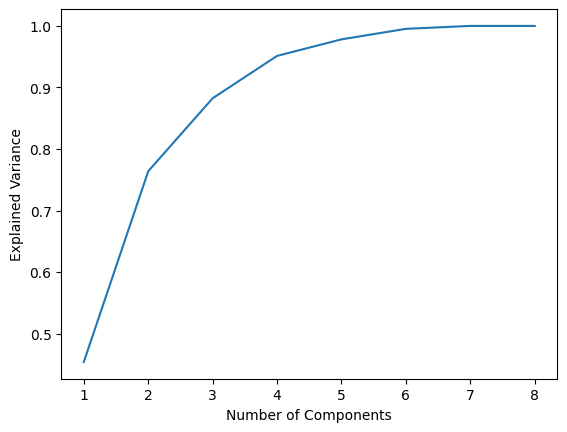

In [340]:
n_compenents = range(1, 9)
explained_variances = []

# standardize data
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

for i in n_compenents:
    pca = PCA(n_components=i)
    pca.fit(X_std)
    X_pca = pca.transform(X_std)
    
    explained_variances.append(sum(pca.explained_variance_ratio_))

plt.plot(n_compenents, explained_variances)
# plt.xticks(range(1, top_k+1))
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")
plt.show()

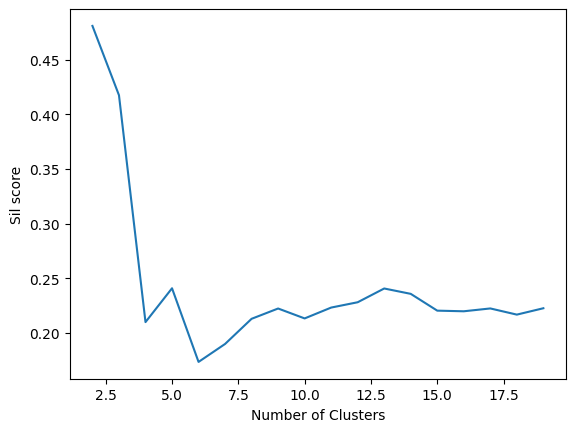

In [348]:
from sklearn.metrics import silhouette_score


#create list to hold error values for each k
sil_scores = []
clusters = np.arange(2, 20)

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

pca = PCA(n_components=5)
pca.fit(X_std)
X_pca = pca.transform(X_std)

for c in clusters:
  
    clust = AgglomerativeClustering(n_clusters=c, metric='euclidean', linkage='ward')
    sil_score = silhouette_score(X_pca, clust.fit_predict(X_pca))
    sil_scores.append(sil_score)



#visualize results
plt.plot(clusters, sil_scores)
# plt.xticks(range(1, top_k+1))
plt.xlabel("Number of Clusters")
plt.ylabel("Sil score")
plt.show()

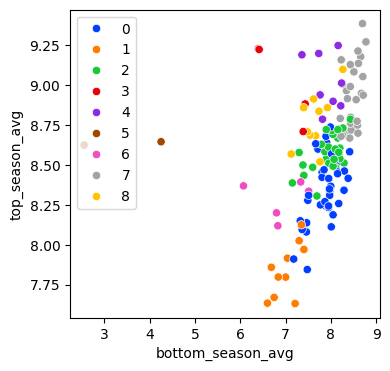

In [354]:

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

pca = PCA(n_components=5)
pca.fit(X_std)
X_pca = pca.transform(X_std)

hier = AgglomerativeClustering(n_clusters=9, metric='euclidean', linkage='ward')
hier.fit(X_pca)

labels = hier.labels_


cluster_df['labels'] = labels

plt.figure(figsize=(4,4))
sns.scatterplot(x=cluster_df['bottom_season_avg'], 
                y=cluster_df['top_season_avg'], 
                hue=labels,
                palette='bright')

plt.show()

In [382]:
cluster_df['labels'].value_counts().sort_index()

labels
0    43
1    10
2    29
3     4
4     8
5     2
6     5
7    27
8    10
Name: count, dtype: int64

In [358]:
cluster_df.groupby('labels')[cluster_cols].mean().round(3)

,top_season_avg,bottom_season_avg,top_bottom_season_gap,all_eps_avg,trend_slope,constant_1,highest_rated_ep,lowest_rated_ep
labels,,,,,,,,
0,8.348,7.863,0.486,8.132,0.004,8.082,9.223,7.342
1,7.842,7.018,0.824,7.484,-0.002,7.562,8.740,5.950
2,8.574,7.920,0.654,8.307,0.000,8.328,9.659,6.900
3,9.012,6.910,2.102,8.358,-0.034,9.110,9.775,4.650
4,9.019,7.918,1.101,8.410,0.029,7.863,9.612,7.162
5,8.636,3.400,5.236,7.707,-0.023,8.961,9.450,2.400
6,8.283,6.909,1.374,7.808,-0.015,8.230,9.500,4.580
7,8.939,8.488,0.450,8.702,0.012,8.481,9.626,7.844
8,8.774,7.652,1.122,8.332,-0.022,8.756,9.420,7.000


In [378]:
cluster_df.loc[cluster_df['labels'].isin([1])].sort_values(by=['labels', 'bottom_season_avg'], ascending=[True, False])


,series.id,top_season_avg,bottom_season_avg,all_eps_avg,trend_slope,constant_1,highest_rated_ep,lowest_rated_ep,n_seasons,n_episodes,title,top_bottom_season_gap,labels
58,tt0280249,7.970000,7.405882,7.642484,0.000318,7.618292,8.6,6.4,9,153,Dragon Ball,0.564118,1
138,tt1513168,8.125000,7.350000,7.606452,-0.010899,7.938863,8.3,6.8,8,62,Through the Wormhole,0.775000,1
19,tt0094525,8.025000,7.300000,7.642857,0.008223,7.359155,8.5,6.9,13,70,Poirot,0.725000,1
0,tt0052520,7.630556,7.211111,7.448718,-0.003391,7.711555,9.1,5.6,5,156,The Twilight Zone,0.419444,1
1,tt0053488,7.915385,7.042308,7.538462,-0.013078,8.041967,8.4,6.5,3,78,The Bugs Bunny Show,0.873077,1
51,tt0229889,7.796774,7.002564,7.421711,-0.000424,7.486001,9.6,6.2,8,304,El Chavo del Ocho,0.794210,1
82,tt0421291,7.797143,6.839286,7.545789,-0.001346,7.672990,8.4,6.4,6,190,Avrupa Yakasi,0.957857,1
17,tt0092455,7.669231,6.748000,7.317614,0.004033,6.964753,9.4,3.3,7,176,Star Trek: The Next Generation,0.921231,1
18,tt0094517,7.858333,6.685714,7.569036,0.004006,7.176496,9.0,6.3,11,197,Mystery Science Theater 3000,1.172619,1
71,tt0380136,7.633333,6.600000,7.105605,-0.003207,7.647604,8.1,5.1,21,339,QI,1.033333,1


In [377]:
for i in cluster_df.loc[cluster_df['labels'].isin([7])].sort_values(by='title').title.tolist():
    print(i)

Anne with an E
Attack on Titan
Better Call Saul
Breaking Bad
Clarkson's Farm
Daredevil
Dark
Gullak
Haikyu!!
Hannibal
Kota Factory
Mob Psycho 100
Mr. Robot
Narcos
Nathan for You
Panchayat
Peaky Blinders
Pose
Sons of Anarchy
Spartacus
Succession
The Bear
The Newsroom
The Sopranos
The Wire
Wentworth
Young Justice


In [360]:
for c in cluster_df['labels'].unique():
    titles = cluster_df.loc[cluster_df['labels']==c].sort_values(by='title').title
    print(f"\nCluster number {c}")
    print(titles)


Cluster number 1
82                      Avrupa Yakasi
58                        Dragon Ball
51                  El Chavo del Ocho
18       Mystery Science Theater 3000
19                             Poirot
71                                 QI
17     Star Trek: The Next Generation
1                 The Bugs Bunny Show
0                   The Twilight Zone
138              Through the Wormhole
Name: title, dtype: object

Cluster number 0
133                          Archer
125                           As If
27      Batman: The Animated Series
77             Battlestar Galactica
69                 Chappelle's Show
209                   Critical Role
54             Curb Your Enthusiasm
68                         Deadwood
228                     Derry Girls
197                    Detectorists
145                   Downton Abbey
50                    Dragon Ball Z
179                       Endeavour
31                       Father Ted
239     Formula 1: Drive to Survive
65               

# Declining ratings

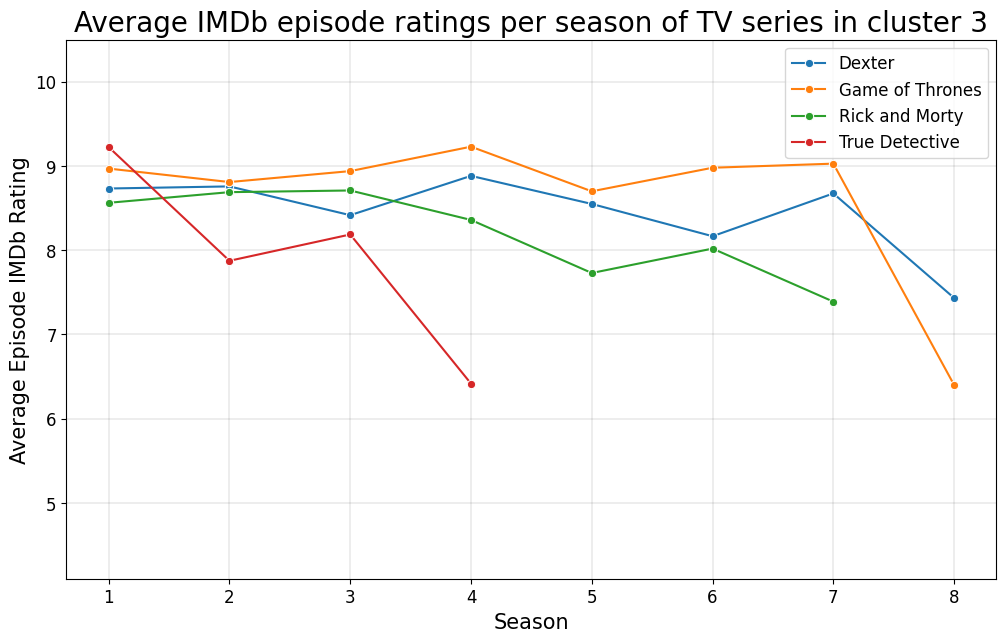

In [361]:
c = 3
titles_for_plot = cluster_df.loc[cluster_df['labels']==c]['title'].values
data_for_plot = df.loc[df['title'].isin(titles_for_plot)].groupby(['title','season'])['aggregateRating'].mean().reset_index()

fig, ax = plt.subplots(1,1, figsize=(12, 7))

sns.lineplot(x="season",
             y="aggregateRating",
            hue="title",
            data=data_for_plot,
             marker='o'
          )
           
plt.ylim(4.1, 10.5)  # Set the y-axis limits from 0 to 8

ax.axes.set_title(f"Average IMDb episode ratings per season of TV series in cluster {c}",fontsize=20)
ax.set_xlabel("Season",fontsize=15)
ax.set_ylabel("Average Episode IMDb Rating",fontsize=15)

ax.yaxis.set_tick_params(labelsize = 12)
ax.xaxis.set_tick_params(labelsize = 12)

plt.grid(True, color='black', linewidth=.1)

plt.legend(fontsize='large')

plt.show()

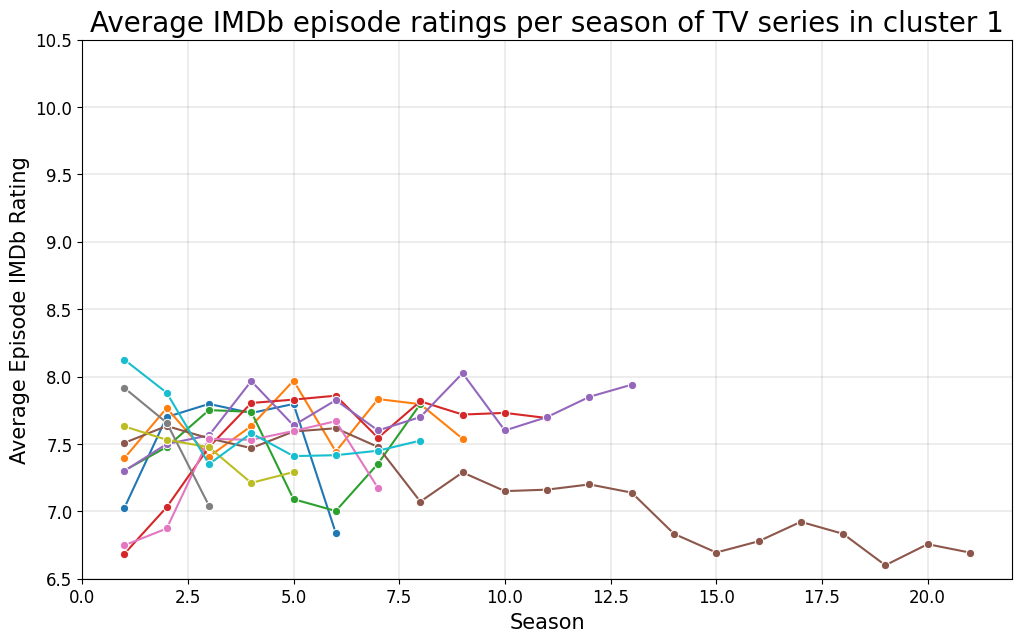

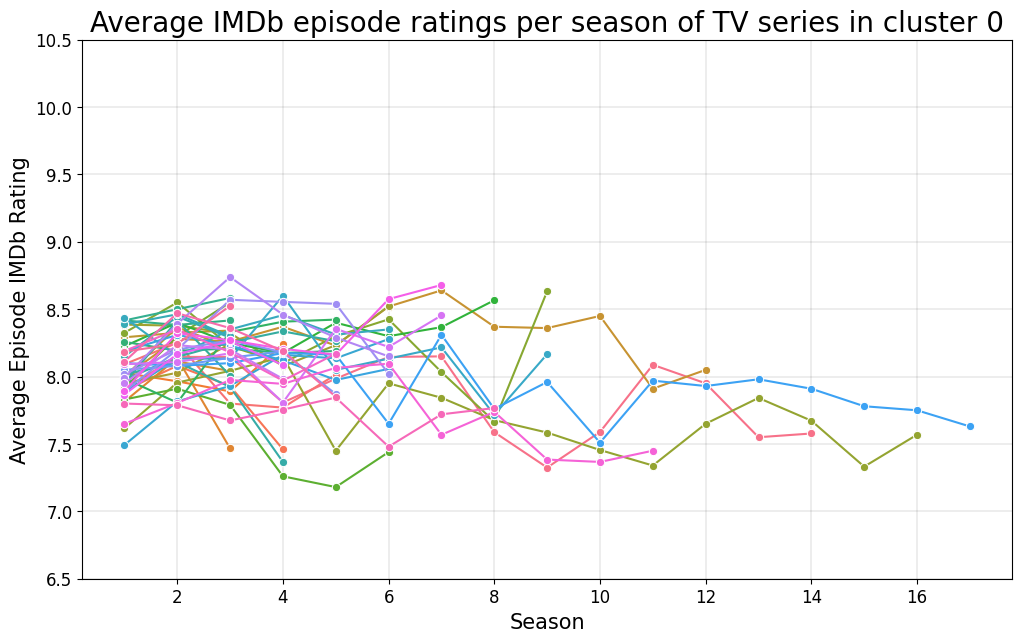

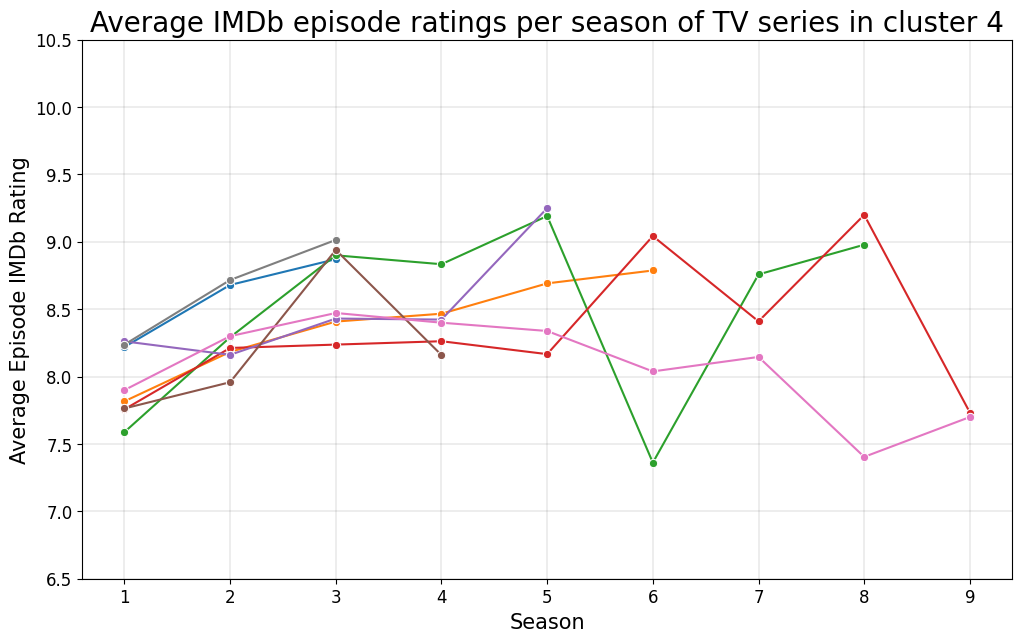

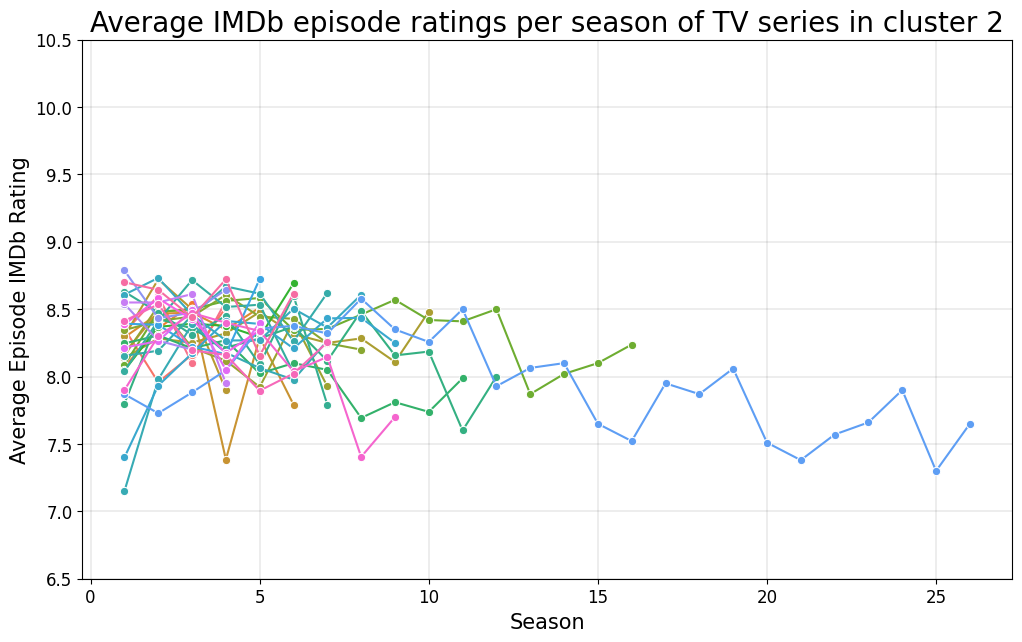

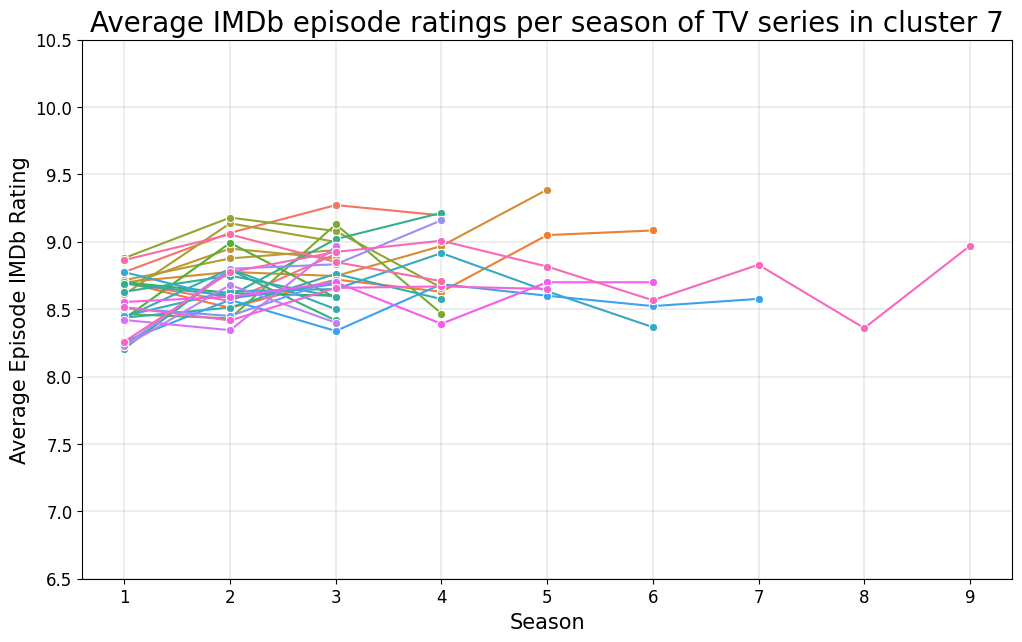

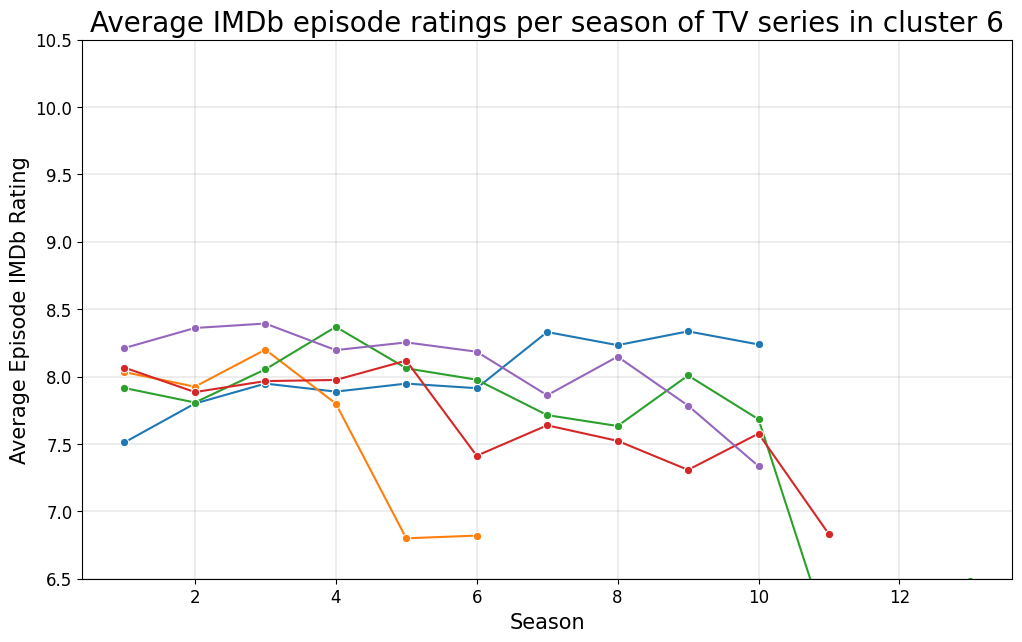

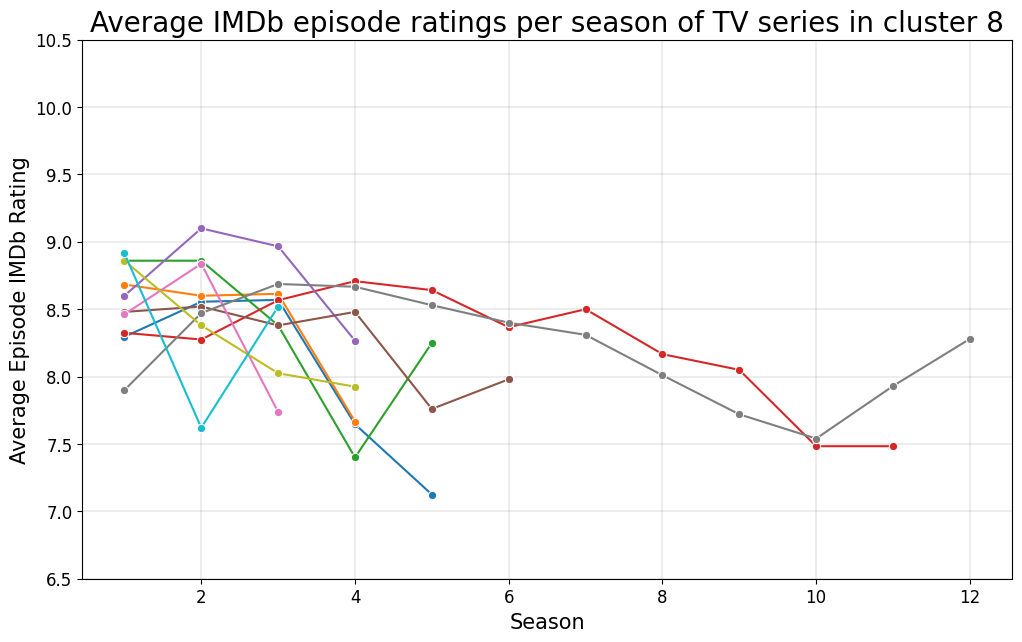

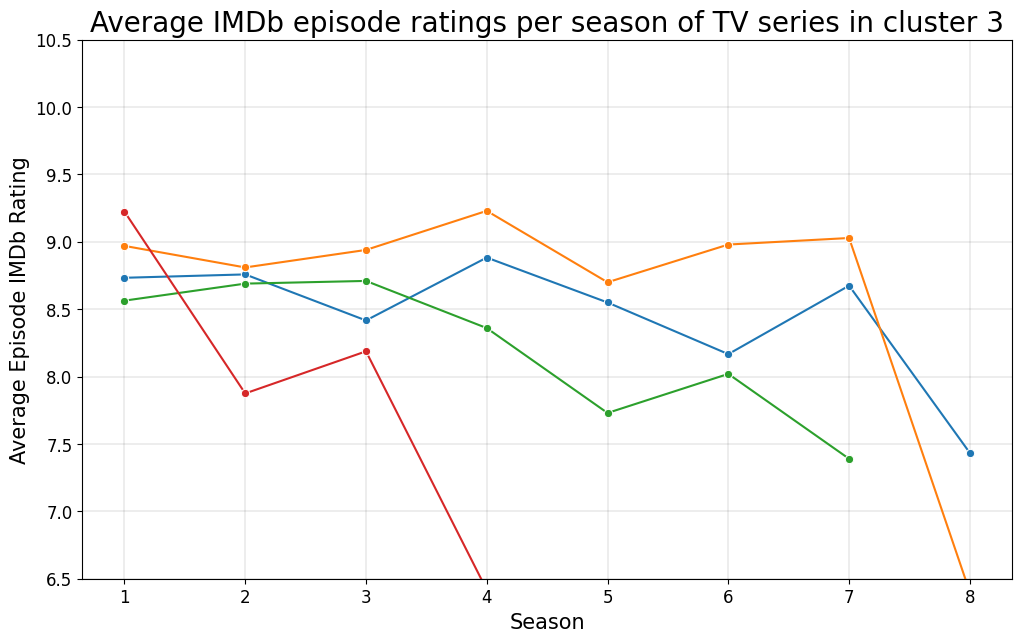

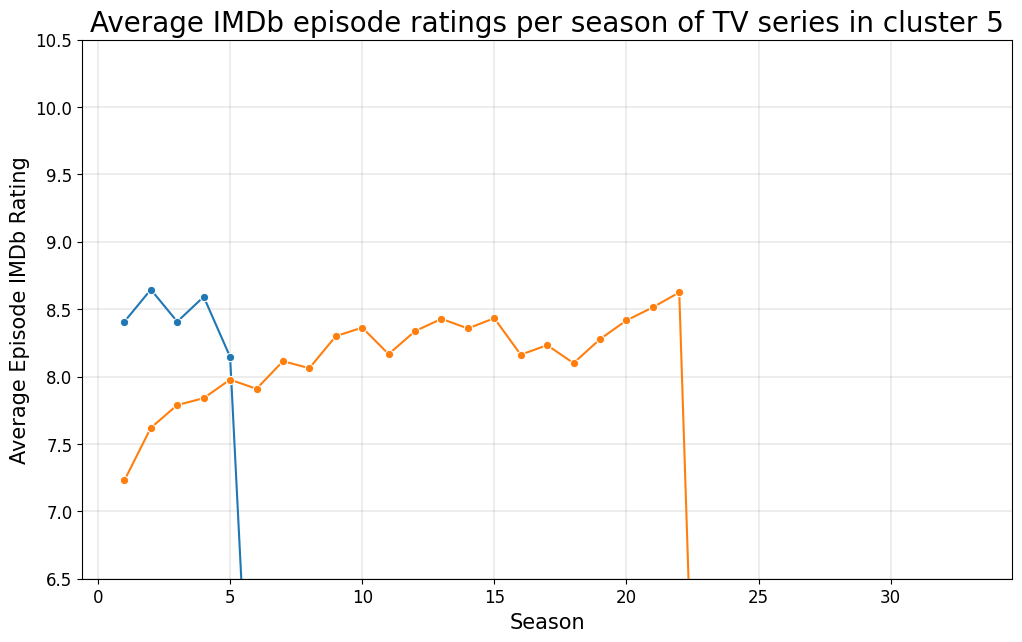

In [364]:

for c in cluster_df['labels'].unique():
    titles_for_plot = cluster_df.loc[cluster_df['labels']==c]['title'].values
    data_for_plot = df.loc[df['title'].isin(titles_for_plot)].groupby(['title','season'])['aggregateRating'].mean().reset_index()
    
    fig, ax = plt.subplots(1,1, figsize=(12, 7))
    
    sns.lineplot(x="season",
                 y="aggregateRating",
                hue="title",
                data=data_for_plot,
                 marker='o',
                 legend=False
              )
               
    plt.ylim(6.5, 10.5)  # Set the y-axis limits from 0 to 8
    
    ax.axes.set_title(f"Average IMDb episode ratings per season of TV series in cluster {c}",fontsize=20)
    ax.set_xlabel("Season",fontsize=15)
    ax.set_ylabel("Average Episode IMDb Rating",fontsize=15)
    
    ax.yaxis.set_tick_params(labelsize = 12)
    ax.xaxis.set_tick_params(labelsize = 12)
    
    plt.grid(True, color='black', linewidth=.1)
    
    # plt.legend(fontsize='large')
    
    plt.show()